<a href="https://colab.research.google.com/github/thales20266/Projeto-Transfer-Learning/blob/main/Transfer_learning_Fine_tuning_(Ajuste_fino)_PT_BR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning / Fine-tuning (Ajuste fino)

Este tutorial vai guiar você pelo processo de usar transfer learning para treinar um classificador de imagens preciso a partir de um número relativamente pequeno de amostras de treinamento.

De forma geral, transfer learning refere-se ao processo de aproveitar o conhecimento aprendido em um modelo para o treinamento de outro modelo.

Mais especificamente, o processo envolve pegar uma rede neural existente que já foi previamente treinada com bom desempenho em um dataset grande, e usá-la como base para um novo modelo, aproveitando a precisão da rede anterior em uma nova tarefa.

Esse método se tornou popular nos últimos anos para melhorar o desempenho de redes neurais treinadas em datasets pequenos; a intuição é que o novo dataset pode ser muito pequeno para alcançar um bom desempenho sozinho, mas sabemos que a maioria das redes neurais, ao aprender características de imagens, geralmente aprendem padrões semelhantes, especialmente nas camadas iniciais (onde detectam bordas, formas básicas, manchas, etc.).

O transfer learning só se tornou viável graças à disponibilização de modelos de última geração como código aberto. Para os modelos que tiveram melhor desempenho em tarefas de classificação de imagens (como no ILSVRC), tornou-se prática comum publicar não apenas a arquitetura, mas também os pesos treinados. Isso permite que qualquer pessoa utilize esses classificadores de imagens de ponta para melhorar o desempenho de seus próprios modelos específicos de tarefa.

## Extração de características vs. Fine-tuning (ajuste fino)

Em um extremo, o transfer learning pode envolver pegar a rede pré-treinada, congelar os pesos, e usar uma de suas camadas internas (geralmente a última) como extrator de características, utilizando essas features como entrada para uma rede neural menor.

No outro extremo, podemos começar com a rede pré-treinada, mas permitir que alguns dos pesos (geralmente da última camada ou últimas camadas) sejam modificados.
Esse procedimento é chamado de fine-tuning (ajuste fino), porque estamos ajustando levemente os pesos da rede pré-treinada para a nova tarefa.
Normalmente treinamos esse tipo de rede com uma taxa de aprendizado menor, já que esperamos que as features aprendidas já sejam relativamente boas e não precisem de mudanças drásticas.

Às vezes, usamos uma abordagem intermediária: congelamos apenas as camadas iniciais (mais genéricas), mas fazemos fine-tuning nas camadas finais.
Qual estratégia usar depende do tamanho do dataset, do número de classes e de quanto ele se assemelha ao dataset original em que a rede foi treinada (ou seja, se pode se beneficiar dos mesmos extratores de características já aprendidos).

## Procedimento

Neste guia, vamos seguir o processo de carregar um classificador de imagens de última geração com 1000 classes — o VGG16, que venceu o desafio ImageNet em 2014 — e usá-lo como um extrator de características fixo para treinar um classificador customizado menor em nossas próprias imagens.

Com apenas algumas mudanças no código, também é possível aplicar o fine-tuning.

## O que faremos:

Carregar o VGG16.

Remover sua camada final (softmax de 1000 classes do ImageNet).

Substituí-la por uma nova camada de classificação, compatível com as classes do nosso dataset.

Congelar todos os pesos da rede, exceto os da nova camada final.

Treinar a nova camada no nosso dataset.

Também vamos comparar esse método com treinar uma rede pequena do zero no novo dataset — e veremos como o transfer learning melhora significativamente a acurácia.

## Nosso dataset de teste

Será usado um dataset com aproximadamente 25000 imagens pertencentes a 2 classes (porém será usado apenas 5% das imagens para não sobrecarregar o sistema)

O classificador treinado atinge em torno de 80% de acurácia.

É importante notar que essa estratégia escala bem até mesmo para conjuntos de imagens muito pequenos (algumas centenas ou menos).

O desempenho será menor com poucos exemplos por classe (como esperado), mas ainda assim impressionante dadas as limitações normais.

In [5]:
# Comando mágico do Jupyter Notebook para exibir gráficos diretamente no notebook
%matplotlib inline

import os

# Caso esteja usando Theano com GPU (hoje em dia quase sempre se usa TensorFlow como backend do Keras)
# os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# Utilitário do Keras para carregar e pré-processar imagens
from keras.preprocessing import image

# Função de pré-processamento compatível com modelos treinados no ImageNet
from keras.applications.imagenet_utils import preprocess_input

# Modelo sequencial do Keras (rede linear, camada após camada)
from keras.models import Sequential

# Camadas clássicas para redes neurais e CNNs
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D

# Classe base para criação de modelos mais flexíveis (usada em transfer learning)
from keras.models import Model


## Carregando um dataset

O primeiro passo será carregar nossos dados.
No exemplo, vamos usar o dataset kagglecatsanddogs_5340
, que contém aproximadamente 25000 imagens rotuladas, pertencentes a 2 categorias de objetos.

No entanto, vamos utilizar apenas 5% das imagens para não sobrecarregar o sistema (principalmente a RAM, e acabar dando erro e reiniciando o nosso ambiente de execução).
Isso é feito para manter o processamento computacional dentro do limite que é fornecido, e também para reduzir o dataset para aproximadamente 1250 imagens.

## Como obter o dataset

Você pode baixar o dataset de duas formas:

Executando o script download.sh na pasta data.

Ou rodando os seguintes comandos no terminal:

    !curl -L -o cats_and_dogs.zip "https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip"

## Usando o seu próprio dataset

Se quiser usar o seu próprio conjunto de imagens, ele deve estar organizado da mesma forma que a pasta "cats_and_dogs/PetImages":

Todas as imagens separadas em subpastas,

Cada subpasta representando uma classe.

Nesse caso, o código abaixo irá carregar corretamente seu dataset customizado, bastando trocar o valor da variável "root" pelo caminho da sua pasta.

⚠️ Se o seu dataset estiver em uma estrutura diferente, você só precisa garantir que carregue uma lista data, onde:

Cada elemento é um dicionário.

"x" representa os dados da imagem (um array 1D do NumPy).

"y" representa o rótulo (um inteiro correspondente à classe).

Use a função auxiliar get_image(path) para carregar as imagens corretamente no array.
As imagens serão redimensionadas para 224x224 automaticamente, porque o modelo VGG16 exige entradas de 224x224 pixels RGB.

👉 Você não precisa redimensionar manualmente seus arquivos, isso já é feito no código.

Se a pasta "PetImages" já estiver dentro da pasta data, o próximo bloco de código será capaz de carregar todas as imagens.

In [6]:
# Baixar o dataset Cats & Dogs diretamente da internet
# (este dataset foi disponibilizado pela Microsoft no Kaggle)
!curl -L -o cats_and_dogs.zip "https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip"

# Extrair o conteúdo do arquivo ZIP para a pasta 'cats_and_dogs'
!unzip -q cats_and_dogs.zip -d cats_and_dogs

# Remover o arquivo ZIP depois da extração para economizar espaço em disco
!rm cats_and_dogs.zip

# Listar o conteúdo da pasta 'cats_and_dogs' para verificar se os arquivos foram extraídos corretamente
!ls cats_and_dogs

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  61.6M      0  0:00:12  0:00:12 --:--:-- 37.8M
 CDLA-Permissive-2.0.pdf   PetImages  'readme[1].txt'


In [7]:
# Caminho principal onde estão as imagens do dataset
root = 'cats_and_dogs/PetImages'

# Lista de categorias que você quer excluir do dataset (aqui está vazio, então não exclui nada)
exclude = []

# Definição das proporções para dividir o dataset:
# 70% treino, 15% validação, e o restante (15%) será usado como teste
train_split, val_split = 0.7, 0.15

# Pega o nome de todas as subpastas dentro do diretório raiz (cada pasta = uma categoria/classe)
categories = [x[0] for x in os.walk(root) if x[0]][1:]

# Remove da lista as categorias que estão na variável "exclude" (se houver)
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

# Exibe as categorias encontradas (no caso: 'cats' e 'dogs')
print(categories)

['cats_and_dogs/PetImages/Cat', 'cats_and_dogs/PetImages/Dog']


## Função para pré-processamento

Esta função é útil para pré-processar os dados, transformando cada item em uma imagem e um vetor de entrada para a rede neural.

In [8]:
# Função auxiliar para carregar uma imagem e retornar:
# 1) a própria imagem (para exibição)
# 2) a imagem processada como vetor de entrada para a rede neural
def get_image(path):

    # Carrega a imagem a partir do caminho fornecido e redimensiona para 224x224 pixels
    # (tamanho exigido pelo modelo VGG16)
    img = image.load_img(path, target_size=(224, 224))

    # Converte a imagem em um array NumPy (altura x largura x canais)
    x = image.img_to_array(img)

    # Adiciona uma dimensão extra no início para representar o "batch" (necessário para Keras)
    # O resultado será shape: (1, 224, 224, 3)
    x = np.expand_dims(x, axis=0)

    # Pré-processamento da imagem compatível com o modelo pré-treinado (subtração de média, etc.)
    x = preprocess_input(x)

    # Retorna a imagem original e o array processado pronto para entrada na rede
    return img, x

## Carregar todas as imagens da pasta raiz

Esta etapa vai percorrer todas as subpastas do dataset e carregar todas as imagens usando a função get_image.
O objetivo é criar uma lista de dados pronta para treinamento, onde cada item terá:

"x" → vetor de entrada processado para a rede

"y" → rótulo da classe correspondente

In [9]:
# Lista que vai armazenar todas as imagens e seus rótulos
data = []

# Percorre cada categoria do dataset
for c, category in enumerate(categories):
    # Pega todos os arquivos de imagem válidos (.jpg, .png, .jpeg) dentro da pasta da categoria
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]

    # Seleciona aleatoriamente 5% das imagens para economizar RAM (pode ser mudado)
    sample_size = int(len(images) * 0.05)
    images = random.sample(images, sample_size)

    # Para cada imagem selecionada
    for img_path in images:
        try:
            # Carrega a imagem e obtém o vetor de entrada processado
            img, x = get_image(img_path)
            # Adiciona à lista 'data' um dicionário com:
            # 'x' → array da imagem
            # 'y' → rótulo da classe (inteiro)
            data.append({'x': np.array(x[0]), 'y': c})
        except Exception as e:
            # Caso algum arquivo esteja corrompido ou não possa ser processado, exibe erro e pula
            print(f"Não foi possível processar a imagem {img_path}. Erro: {e}")
            pass  # Ignora arquivos problemáticos

# Conta o número de classes
num_classes = len(categories)

# Exibe estatísticas básicas do dataset carregado
print(f"Total de imagens carregadas: {len(data)}")
print(f"Número de classes: {num_classes}")


Total de imagens carregadas: 1250
Número de classes: 2


## Embaralhar a ordem dos dados

Nesta etapa, vamos misturar aleatoriamente a lista "data".
Isso é importante para que, ao separar em treino, validação e teste, cada conjunto receba uma distribuição equilibrada de imagens de todas as classes, evitando que imagens de uma mesma classe fiquem agrupadas.

In [10]:
# Embaralha aleatoriamente a lista 'data' para garantir que as imagens
# fiquem misturadas antes de separar em treino, validação e teste
random.shuffle(data)

## Criar divisão de treino / validação / teste (70%, 15%, 15%)

Nesta etapa, vamos separar a lista "data" em três conjuntos:

Treino (70%) → usado para ajustar os pesos do modelo.

Validação (15%) → usado para avaliar o modelo durante o treino e ajustar hiperparâmetros.

Teste (15%) → usado para medir a performance final do modelo, sem que ele tenha visto essas imagens antes.

In [11]:
# Calcula o índice final do conjunto de treino (70% dos dados)
idx_val = int(train_split * len(data))

# Calcula o índice final do conjunto de validação (70% + 15% = 85% dos dados)
idx_test = int((train_split + val_split) * len(data))

# Cria o conjunto de treino com os primeiros 70% dos dados
train = data[:idx_val]

# Cria o conjunto de validação com os 15% seguintes
val = data[idx_val:idx_test]

# Cria o conjunto de teste com os 15% restantes
test = data[idx_test:]

## Separar os dados das labels

Nesta etapa, vamos separar os arrays de entrada (x) e os rótulos (y) para cada conjunto (treino, validação e teste).
Isso é necessário porque as redes neurais do Keras esperam os dados de entrada (X) e os labels (y) como variáveis separadas.

In [12]:
# Para o conjunto de treino:
# - x_train → array NumPy contendo todas as imagens (entrada da rede)
# - y_train → lista com os rótulos correspondentes
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]

# Para o conjunto de validação:
# - x_val → imagens de validação
# - y_val → rótulos de validação
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]

# Para o conjunto de teste:
# - x_test → imagens de teste
# - y_test → rótulos de teste
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]

# Exibe os rótulos do conjunto de teste
print(y_test)

[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1]


## Pré-processar os dados novamente

Nesta etapa, vamos garantir que os arrays de imagens:

Estejam no tipo float32 (requisito comum para redes neurais).

Estejam normalizados entre 0 e 1, para que o treinamento seja mais estável e rápido.

Isso é especialmente importante para redes pré-treinadas, que esperam entradas normalizadas de forma consistente.

In [13]:
# Normaliza os arrays de imagem dividindo os valores dos pixels por 255
# Isso transforma os valores de 0-255 para 0-1
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Converte os rótulos (labels) em vetores one-hot
# Ex.: se temos 3 classes, o rótulo 1 vira [0, 1, 0]
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Exibe a forma do array de teste para conferir se a conversão deu certo
print(y_test.shape)

(188, 2)


# Resumo do que já fizemos até aqui

## Importação de bibliotecas

Keras, NumPy, Matplotlib e utilitários para manipulação de imagens.

## Download e extração do dataset

Dataset Cats & Dogs baixado, extraído e organizado em subpastas por classe.

## Carregamento das imagens

Função get_image para carregar cada imagem, redimensionar para 224x224 e pré-processar para VGG16.

## Construção da lista de dados

Cada item da lista data contém um dicionário com:

"x" → vetor de entrada da imagem

"y" → rótulo da classe

## Embaralhamento do dataset

random.shuffle(data) para garantir distribuição equilibrada nas divisões.

## Divisão em treino, validação e teste

Proporção: 70% treino, 15% validação, 15% teste.

## Separação de imagens e labels

Arrays NumPy para imagens (x_train, x_val, x_test).

One-hot encoding para rótulos (y_train, y_val, y_test).

## Normalização dos dados

Valores de pixel convertidos para float32 e normalizados entre 0 e 1.

✅ Agora, os dados estão prontos para serem usados em um modelo de rede neural, seja um modelo pequeno do zero ou uma rede pré-treinada (VGG16) com transfer learning.

In [14]:
# Exibe um resumo do dataset carregado e processado

# Quantidade total de imagens e número de categorias
print("Finalizado o carregamento de %d imagens de %d categorias"%(len(data), num_classes))

# Quantidade de imagens em cada subset: treino, validação e teste
print("Divisão treino / validação / teste: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))

# Formato (shape) dos arrays de entrada e rótulos do conjunto de treino
print("Formato dos dados de treino: ", x_train.shape)
print("Formato dos rótulos de treino: ", y_train.shape)

Finalizado o carregamento de 1250 imagens de 2 categorias
Divisão treino / validação / teste: 875, 187, 188
Formato dos dados de treino:  (875, 224, 224, 3)
Formato dos rótulos de treino:  (875, 2)


Se tudo funcionou corretamente, você deve ter carregado um monte de imagens e dividido em três conjuntos: treino, validação e teste.

O formato do conjunto de treino deve ser (n, 224, 224, 3), onde n é o número de imagens de treino.

Os rótulos devem ter formato (n, c), onde c é o número de classes (2 no caso do PetImages).

Observação: dividimos os dados em três subsets — treino (train), validação (val) e teste (test) — para avaliar corretamente a acurácia do classificador.

Durante o treino, o otimizador usa o conjunto de validação para monitorar o desempenho e ajudar a determinar o gradiente, evitando overfitting no conjunto de treino.

O conjunto de teste não é usado durante o treino; ele é reservado para avaliar a acurácia final do modelo depois que o treinamento terminou.

Agora, vamos dar uma olhada rápida em algumas imagens do nosso dataset para conferir visualmente.

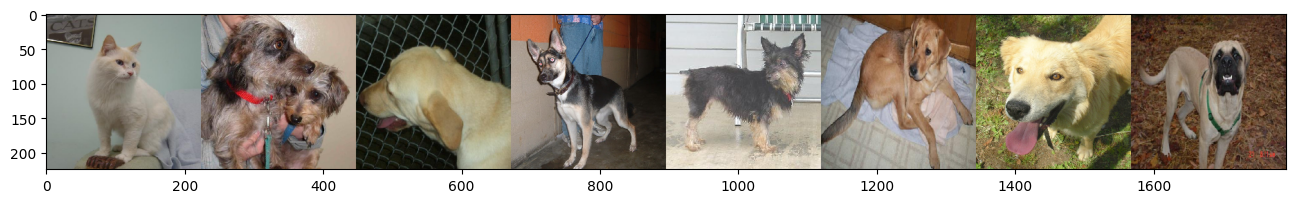

In [15]:
# Cria uma lista com todos os arquivos de imagem válidos (.jpg, .png, .jpeg) no dataset
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root)
          for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]

# Seleciona aleatoriamente 8 índices de imagens para exibição
idx = [int(len(images) * random.random()) for i in range(8)]

# Carrega as 8 imagens selecionadas, redimensionando para 224x224 pixels
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]

# Concatena as 8 imagens horizontalmente (lado a lado) para exibição
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)

# Cria uma figura do Matplotlib com tamanho 16x4 polegadas
plt.figure(figsize=(16,4))

# Exibe a imagem concatenada
plt.imshow(concat_image)

# Primeiro, treinando uma rede neural do zero

Antes de fazermos transfer learning, vamos construir uma rede neural do zero para classificação no nosso dataset.
Isso nos dará uma linha de base (baseline) para comparar depois com o desempenho da rede com transfer learning.

## A rede que vamos construir contém:

4 camadas convolucionais alternadas com camadas de max-pooling.

Um dropout após cada par de conv/pooling, para evitar overfitting.

Depois da última camada de pooling, adicionamos:

Uma camada fully-connected (densa) com 256 neurônios.

Outro dropout.

Finalmente, uma camada softmax de classificação para nossas classes.

Função de perda (loss):

categorical cross-entropy (usada para classificação multi-classe).

Algoritmo de aprendizado:

AdaDelta (um otimizador adaptativo que ajusta a taxa de aprendizado automaticamente).

## ⚠️ Observações:

Esse modelo é apenas um baseline aproximado.

Podemos melhorar o desempenho usando uma rede maior ou outro otimizador, mas o objetivo aqui é entender o processo antes de aplicar transfer learning.

Depois de compilar a rede, podemos rodar:

    model.summary()


Para obter um resumo das camadas e parâmetros do modelo.

In [16]:
# Construção da rede neural do zero usando Keras Sequential
model = Sequential()

# Exibe as dimensões de entrada do modelo (altura, largura, canais)
print("Dimensões de entrada: ", x_train.shape[1:])

# ------------------------
# Primeira camada convolucional + ReLU + MaxPooling
# ------------------------
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))  # 32 filtros 3x3
model.add(Activation('relu'))                                   # Função de ativação ReLU
model.add(MaxPooling2D(pool_size=(2, 2)))                      # MaxPooling 2x2

# ------------------------
# Segunda camada convolucional + ReLU + MaxPooling
# ------------------------
model.add(Conv2D(32, (3, 3)))                                 # 32 filtros 3x3
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout de 25% após duas camadas conv/pooling para evitar overfitting
model.add(Dropout(0.25))

# ------------------------
# Terceira camada convolucional + ReLU + MaxPooling
# ------------------------
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# ------------------------
# Quarta camada convolucional + ReLU + MaxPooling
# ------------------------
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout de 25% novamente
model.add(Dropout(0.25))

# ------------------------
# Camadas totalmente conectadas (fully connected)
# ------------------------
model.add(Flatten())                  # Achata os mapas de características em vetor 1D
model.add(Dense(256))                 # Camada densa com 256 neurônios
model.add(Activation('relu'))         # ReLU

model.add(Dropout(0.5))               # Dropout de 50% antes da saída

# ------------------------
# Camada de saída
# ------------------------
model.add(Dense(num_classes))         # Camada densa com número de neurônios = número de classes
model.add(Activation('softmax'))      # Softmax para classificação multi-classe

# Exibe um resumo do modelo, mostrando camadas e parâmetros
model.summary()

Dimensões de entrada:  (224, 224, 3)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

Criamos uma rede de tamanho médio com aproximadamente 1,2 milhões de pesos e biases (os parâmetros do modelo).

A maior parte desses parâmetros está concentrada na camada totalmente conectada antes do softmax (dense).

Agora, podemos treinar o modelo:

5 épocas (epochs=5)

Batch size 128 (batch_size=128)

Também vamos registrar o histórico de treinamento (history) para depois plotar a evolução da loss e acurácia ao longo das épocas.

In [17]:
# Compila o modelo
# - loss: função de perda para classificação multi-classe
# - optimizer: algoritmo de otimização (Adam)
# - metrics: métrica de avaliação (acurácia)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Treina o modelo com os dados de treino
# - batch_size=128: tamanho do lote de imagens processadas por vez
# - epochs=10: número de épocas (passadas completas sobre todo o dataset)
# - validation_data: conjunto de validação usado para monitorar desempenho durante o treino
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=5,
                    validation_data=(x_val, y_val))

Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 69s 9s/step - accuracy: 0.5050 - loss: 0.7020 - val_accuracy: 0.5187 - val_loss: 0.6887
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 60s 8s/step - accuracy: 0.5218 - loss: 0.6909 - val_accuracy: 0.5722 - val_loss: 0.6905
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 9s/step - accuracy: 0.5610 - loss: 0.6833 - val_accuracy: 0.5134 - val_loss: 0.6865
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - accuracy: 0.6089 - loss: 0.6717 - val_accuracy: 0.4920 - val_loss: 0.6926
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 9s/step - accuracy: 0.5812 - loss: 0.6662 - val_accuracy: 0.6310 - val_loss: 0.6631


## Plotar a evolução da loss e acurácia de validação ao longo do treino

Nesta etapa, vamos usar os dados armazenados em history para visualizar como a rede está aprendendo.

Validation loss → mostra se o modelo está ajustando bem aos dados de validação ou se está overfitting.

Validation accuracy → mostra a acurácia do modelo no conjunto de validação a cada época.

Esses gráficos ajudam a diagnosticar problemas e a entender se o treinamento está convergindo corretamente.

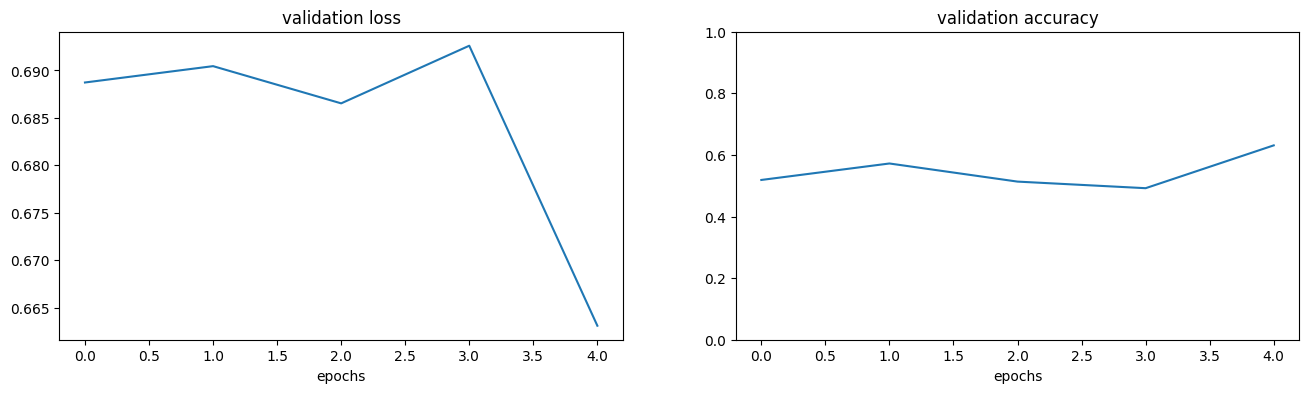

In [18]:
# Cria uma figura do Matplotlib com tamanho 16x4 polegadas
fig = plt.figure(figsize=(16,4))

# ------------------------
# Subplot 1: Validation Loss
# ------------------------
ax = fig.add_subplot(121)                         # Primeiro subplot à esquerda
ax.plot(history.history["val_loss"])             # Plota a loss do conjunto de validação
ax.set_title("validation loss")                  # Título do gráfico
ax.set_xlabel("epochs")                          # Label do eixo x

# ------------------------
# Subplot 2: Validation Accuracy
# ------------------------
ax2 = fig.add_subplot(122)                        # Segundo subplot à direita
ax2.plot(history.history["val_accuracy"])        # Plota a acurácia do conjunto de validação
ax2.set_title("validation accuracy")             # Título do gráfico
ax2.set_xlabel("epochs")                         # Label do eixo x
ax2.set_ylim(0, 1)                               # Define limite do eixo y entre 0 e 1

# Exibe os gráficos
plt.show()

Observe que a validation loss começa a subir após cerca de 2 épocas, mesmo que a acurácia de validação permaneça entre 50% e 60%. Mas logo já cai depois da 3 época.

Isso sugere que o modelo começa a overfitting nesse ponto, mas acaba corrigindo.

O melhor desempenho teria sido alcançado se tivéssemos usado early stopping por volta dessa época.

No entanto, mesmo parando cedo, a acurácia provavelmente não teria passado de 60%.

Também podemos obter uma avaliação final executando o modelo no conjunto de treinamento.

Fazendo isso, podemos conferir a acurácia final do modelo e ver quão bem ele aprendeu os dados de treino.

In [19]:
# Avalia o modelo usando o conjunto de teste
# - x_test, y_test: dados e rótulos do conjunto de teste
# - verbose=0: não exibe progresso detalhado durante a avaliação
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

# Exibe a loss final no conjunto de teste
print('Test loss:', loss)

# Exibe a acurácia final no conjunto de teste
print('Test accuracy:', accuracy)

Test loss: 0.637714147567749
Test accuracy: 0.6489361524581909


Finalmente, vemos que conseguimos atingir uma acurácia (top-1) de cerca de 65% (arredondando).

Para apenas 1250 imagens, não é ruim, considerando que uma estratégia aleatória teria dado apenas cerca de 1% de acurácia.

## Transfer learning começando com uma rede existente

Agora podemos avançar para a estratégia principal para treinar um classificador de imagens em nosso pequeno dataset:

Começar com uma rede maior já treinada.

Para começar, vamos carregar o VGG16 do Keras, que foi treinado no ImageNet com os pesos já salvos online.

Se for a primeira vez carregando o VGG16, será necessário aguardar o download dos pesos.

Uma vez carregada a rede, podemos novamente inspecionar suas camadas usando o método summary().

In [20]:
# Carrega o modelo VGG16 pré-treinado no ImageNet
# - weights='imagenet': carrega os pesos já treinados no dataset ImageNet
# - include_top=True: inclui a camada final de classificação (softmax 1000 classes do ImageNet)
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)

# Exibe um resumo completo do modelo VGG16
# Mostra todas as camadas, tipos, saídas e número de parâmetros
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

## Observe que o VGG16 é MUITO maior que a rede que construímos anteriormente.

Ele contém 13 camadas convolucionais e duas camadas totalmente conectadas no final,

Possui mais de 138 milhões de parâmetros, cerca de 100 vezes mais do que nossa primeira rede.

Assim como nossa primeira rede, a maior parte dos parâmetros está nas conexões que entram na primeira camada totalmente conectada.

## O VGG16 foi projetado para resolver o ImageNet e atinge:

Top-5 error rate: 8,8% → significa que 91,2% das amostras de teste foram classificadas corretamente dentro das 5 previsões principais.

Top-1 accuracy: 73% → equivalente à métrica que usamos, ou seja, a previsão mais provável está correta.

⚠️ Isso é impressionante, considerando que o ImageNet tem 1000 classes, e um chute aleatório teria apenas 0,1% de acurácia.

## Para usar essa rede em nosso dataset de 2 classes, precisamos substituir a camada final de classificação:

A camada softmax com 1000 neurônios do ImageNet é substituída por uma nova camada softmax com 2 neurônios (ou o número de classes do seu dataset).

## Em termos de implementação:

É mais fácil criar uma cópia do VGG16 desde a camada de entrada até a penúltima camada e depois adicionar nossa nova camada softmax.

Tecnicamente, não removemos nada, apenas ignoramos a última camada original.

## No Keras, isso é feito usando a classe Model:

O input é o mesmo do VGG16 original.

O output é a nova camada softmax, chamada new_classification_layer.

⚠️ Embora pareça que estamos duplicando a rede, internamente o Keras apenas referencia as camadas existentes, então não há sobrecarga de memória.

In [21]:
# Faz uma referência à camada de entrada do VGG16
inp = vgg.input

# Cria uma nova camada softmax com 'num_classes' neurônios (2 no nosso caso)
new_classification_layer = Dense(num_classes, activation='softmax')

# Conecta a nova camada à penúltima camada do VGG16
# - vgg.layers[-2].output: saída da penúltima camada do VGG16
# - 'out' é a referência à saída do nosso novo modelo
out = new_classification_layer(vgg.layers[-2].output)

# Cria um novo modelo do Keras
# - input: mesma entrada do VGG16
# - output: nossa nova camada de classificação
model_new = Model(inp, out)

# Vamos re-treinar essa nova rede (model_new) com nosso novo dataset e rótulos.

## Antes disso, precisamos congelar os pesos e biases de todas as camadas da rede, exceto a nova camada de saída, porque:

Esperamos que os features aprendidos pelo VGG16 ainda sejam relevantes para o novo problema de classificação de imagens.

Isso não é ótimo, mas muito provavelmente melhor do que treinar tudo do zero com nosso dataset limitado.

Para fazer isso, definimos o flag trainable de cada camada como False (exceto na nova camada).

Assim, os pesos e biases das camadas pré-treinadas permanecem fixos, e treinamos apenas a camada final.

## ⚠️ Observação:

Em alguns casos, pode ser interessante não congelar todas as camadas pré-classificação.

Se o dataset tiver suficientes amostras e for muito diferente do ImageNet, talvez seja vantajoso fine-tunar algumas camadas do VGG junto com o novo classificador, ou até todas elas.

No caso do kagglecatsanddogs_5340, vamos apenas fazer feature extraction, pois fine-tuning excessivo pode causar overfitting.

Mas vale testar ambos e comparar os resultados, como exercício.

Depois de congelar as camadas, compilamos o modelo novo com o mesmo otimizador e função de perda que usamos na primeira rede, para garantir comparação justa.

Em seguida, podemos rodar summary() para inspecionar a arquitetura do novo modelo.

In [22]:
# ------------------------
# Congela todas as camadas, exceto a última
# ------------------------
for l, layer in enumerate(model_new.layers[:-1]):   # Percorre todas as camadas, exceto a última
    layer.trainable = False                         # Congela os pesos e biases (não serão atualizados no treino)

# ------------------------
# Garante que a última camada seja treinável
# ------------------------
for l, layer in enumerate(model_new.layers[-1:]):   # Seleciona apenas a última camada
    layer.trainable = True                          # Os pesos desta camada serão atualizados durante o treino

# ------------------------
# Compila o modelo
# ------------------------
# - loss: função de perda para classificação multi-classe
# - optimizer: algoritmo de otimização (Adam)
# - metrics: métrica de avaliação (acurácia)
model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# ------------------------
# Exibe resumo do novo modelo
# ------------------------
# Mostra todas as camadas, quais estão congeladas, tipo e número de parâmetros
model_new.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

## Ao olhar o summary, vemos que a rede é idêntica ao modelo VGG16 que instanciamos antes, exceto a última camada:

A camada softmax de 1000 neurônios foi substituída por uma nova camada softmax com 2 neurônios.

## Além disso:

Ainda temos cerca de 134 milhões de pesos,

Mas a maioria agora é “não treinável”, pois congelamos as camadas correspondentes.

Agora temos apenas 8 mil parâmetros treináveis, o que é 150 vezes menor do que a quantidade de  parâmetros necessários para treinar a primeira rede do zero.

## Como antes, vamos treinar o novo modelo usando:

Mesmos hiperparâmetros (batch size e número de épocas)

Mesmo otimizador (Adam)

Registrando o histórico (history) para depois plotar e analisar a performance.

In [23]:
# Treina o modelo com transfer learning (feature extraction)
history2 = model_new.fit(
    x_train, y_train,               # Dados e rótulos de treino
    batch_size=128,                 # Tamanho do batch
    epochs=5,                      # Número de épocas
    validation_data=(x_val, y_val)) # Conjunto de validação para monitorar performance durante o treino

Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 629s 93s/step - accuracy: 0.4970 - loss: 1.0139 - val_accuracy: 0.7112 - val_loss: 0.6120
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 679s 92s/step - accuracy: 0.5988 - loss: 0.6628 - val_accuracy: 0.5401 - val_loss: 0.6661
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 678s 92s/step - accuracy: 0.6356 - loss: 0.5952 - val_accuracy: 0.8182 - val_loss: 0.4871
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 579s 85s/step - accuracy: 0.7864 - loss: 0.4802 - val_accuracy: 0.7754 - val_loss: 0.4707
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 622s 92s/step - accuracy: 0.8035 - loss: 0.4455 - val_accuracy: 0.8556 - val_loss: 0.4198


A acurácia de validação do nosso modelo fica próxima de 86% no final.

Um melhora de mais de 20% em relação à rede treinada do zero (onde errávamos em 37% das amostras, agora em apenas 14%).

Também é interessante notar que essa rede treina ligeiramente mais rápido que a rede original.

Apesar de ter mais de 100 vezes mais parâmetros!

Isso acontece porque congelar os pesos elimina a necessidade de backpropagation por todas essas camadas, economizando tempo de execução.

Agora, vamos plotar a perda e a acurácia de validação novamente.

Comparando o modelo original treinado do zero (em azul)

Com o modelo com transfer learning (em laranja).

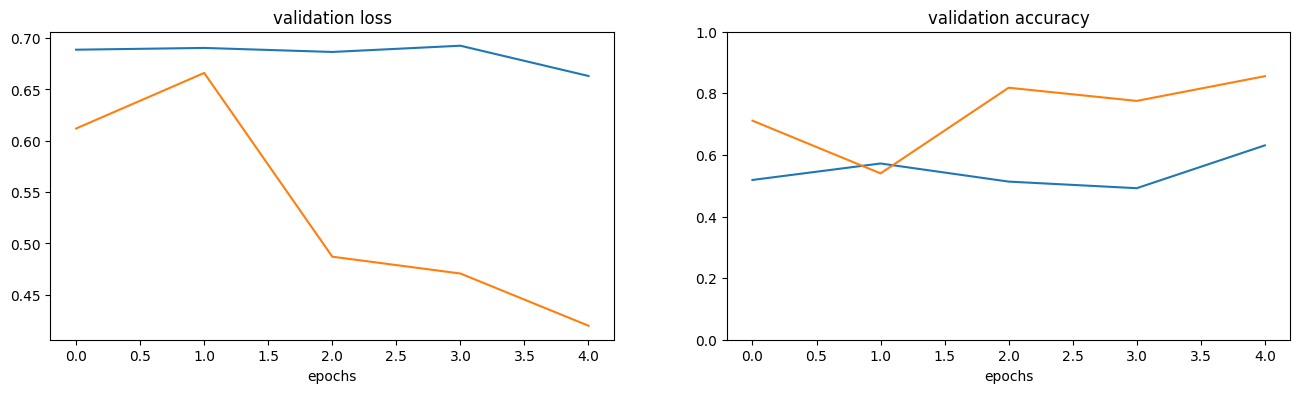

In [24]:
# ------------------------
# Cria uma figura grande para os plots
# ------------------------
fig = plt.figure(figsize=(16,4))

# ------------------------
# Plot da perda de validação (validation loss)
# ------------------------
ax = fig.add_subplot(121)                      # Cria um subplot à esquerda
ax.plot(history.history["val_loss"])           # Plota a perda do modelo treinado do zero (em azul)
ax.plot(history2.history["val_loss"])          # Plota a perda do modelo com transfer learning (em verde)
ax.set_title("validation loss")                # Título do gráfico
ax.set_xlabel("epochs")                         # Label do eixo X

# ------------------------
# Plot da acurácia de validação (validation accuracy)
# ------------------------
ax2 = fig.add_subplot(122)                     # Cria um subplot à direita
ax2.plot(history.history["val_accuracy"])     # Plota acurácia do modelo treinado do zero (em azul)
ax2.plot(history2.history["val_accuracy"])    # Plota acurácia do modelo com transfer learning (em verde)
ax2.set_title("validation accuracy")           # Título do gráfico
ax2.set_xlabel("epochs")                       # Label do eixo X
ax2.set_ylim(0, 1)                             # Limita o eixo Y entre 0 e 1

# ------------------------
# Mostra os gráficos
# ------------------------
plt.show()

## Perceba que:

Enquanto o modelo original começou a sofrer overfitting por volta da época 2, o novo modelo (com transfer learning) continuou diminuindo lentamente sua perda ao longo do tempo, e provavelmente teria melhorado ainda mais sua acurácia com mais épocas.

O novo modelo alcançou aproximadamente 86% de acurácia top-1 no conjunto de validação e continuou melhorando lentamente ao longo de 5 épocas.

## É possível que tivéssemos melhorado o modelo original com:

Regularização melhor

Mais dropout

Mas, mesmo assim, dificilmente conseguiríamos recuperar os >20% de ganho em acurácia obtidos com o transfer learning.

Agora, fazemos a validação final no conjunto de teste, para avaliar o desempenho real do modelo em dados nunca vistos.

In [25]:
# ------------------------
# Avalia o modelo no conjunto de teste
# ------------------------
# x_test, y_test: dados e rótulos do conjunto de teste
# verbose=0: não exibe barra de progresso durante a avaliação
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

# ------------------------
# Exibe os resultados
# ------------------------
print('Test loss:', loss)        # Perda final no conjunto de teste
print('Test accuracy:', accuracy) # Acurácia final no conjunto de teste

Test loss: 0.4001368582248688
Test accuracy: 0.8776595592498779


Para fazer a previsão de uma nova imagem, basta rodar o código abaixo para obter as probabilidades de cada classe.

Ou seja:

Cada saída será um vetor com valores entre 0 e 1

O valor indica a probabilidade do modelo achar que a imagem pertence a cada classe

A soma de todas as probabilidades será 1 (por causa da camada softmax)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
0


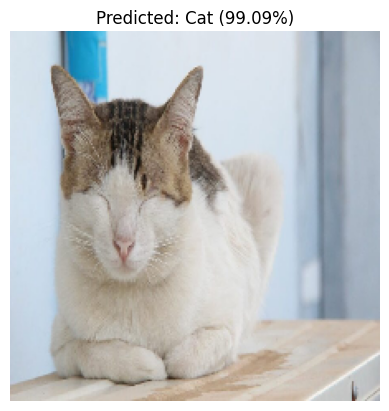

Categorias mapeadas:
0 -> cats_and_dogs/PetImages/Cat
1 -> cats_and_dogs/PetImages/Dog


In [28]:
# ------------------------
# Definimos os nomes das classes para facilitar a leitura
# ------------------------
class_names = ['Cat', 'Dog']

# ------------------------
# Carrega a imagem e transforma em vetor de entrada para o modelo
# ------------------------
img, x = get_image('teste1/gato1.jpg')  # img: imagem original, x: array preprocessado

# ------------------------
# Faz a previsão das probabilidades de cada classe
# ------------------------
probabilities = model_new.predict([x])   # Retorna vetor com probabilidade para cada classe

# ------------------------
# Determina a classe com maior probabilidade
# ------------------------
pred_class_idx = np.argmax(probabilities)          # Índice da classe com maior probabilidade
pred_class_name = class_names[pred_class_idx]     # Nome da classe correspondente

# ------------------------
# Mostra o índice da classe prevista
# ------------------------
print(pred_class_idx)

# ------------------------
# Exibe a imagem com a previsão no título
# ------------------------
plt.imshow(img)                                   # Mostra a imagem original
plt.axis('off')                                   # Remove os eixos
plt.title(f"Predicted: {pred_class_name} ({probabilities[0][pred_class_idx]*100:.2f}%)") # Mostra classe prevista e probabilidade
plt.show()

# ------------------------
# Mostra o mapeamento de índices para categorias
# ------------------------
print("Categorias mapeadas:")
for idx, cat in enumerate(categories):
    print(idx, "->", cat)  # Cada linha mostra índice -> nome da classe


# Melhorando os resultados

Alcançar 78,2% de acurácia top-1 em 97 classes, distribuídas de forma relativamente uniforme, é um resultado muito bom.

Não é tão impressionante quanto o VGG16 original, que atingiu 73% de acurácia top-1 em 1000 classes.

Mesmo assim, é muito melhor que o que conseguimos com a rede treinada do zero.

Ainda há espaço para melhorias.

Algumas técnicas que poderiam aumentar a performance:

Data augmentation (aumento de dados):

Refere-se a usar modificações das imagens de treino, como distorções, rotações, redimensionamentos, alterações de iluminação, etc.

Isso aumenta o tamanho do conjunto de treino e ajuda o modelo a ser mais tolerante a essas variações.

Alterar hiperparâmetros e otimizador:

Usar outro otimizador

Adicionar mais regularização ou dropout

Ajustar outros hiperparâmetros

Treinar por mais tempo

Naturalmente, mais épocas podem levar a melhor desempenho, se o modelo não estiver sobreajustando (overfitting).

Um exemplo mais avançado de transfer learning no Keras, usando aumento de dados para um dataset pequeno de 2 classes, pode ser visto no blog do Keras
.